In [1]:
from datetime import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from termcolor import cprint
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier




C:\Users\admin\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
%%time
#if data.csv not exist it will go inside if
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    files = ['combined_data_1.txt','combined_data_2.txt','combined_data_3.txt','combined_data_4.txt']
    row = list()
    
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()


Wall time: 0 ns


In [3]:
# creating data frame from our output csv file.
if not os.path.isfile("NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("data.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

In [114]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("NetflixData.pkl"):
    Final_Data.to_pickle("NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("NetflixData.pkl")

In [5]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [119]:
Final_Data.shape

(100480507, 4)

In [12]:
#Remove after all the analysis
Final_Data=Final_Data.head(900000)

In [10]:
Final_Data.tail()

,MovieID,CustID,Ratings,Date
10820234,2122,2621913,1,2000-12-26
47539569,8585,757756,3,2000-12-26
14437547,2782,757756,4,2000-12-26
65285375,11929,680622,4,2000-12-26
81302190,14601,408200,5,2000-12-26


In [122]:

Final_Data.describe()["Ratings"]

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [8]:
#Checking the null values
Final_Data.isnull().sum()

MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64

In [8]:
print("Number of Duplicate rows : "+str(Final_Data.duplicated(["MovieID","CustID","Ratings"]).sum()))

Number of Duplicate rows : 0


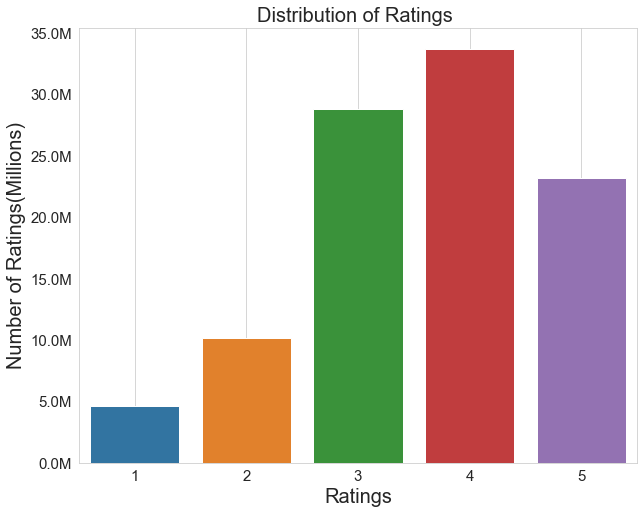

Wall time: 4.77 s


In [9]:
%%time 
plt.figure(figsize = (10, 8))
ax = sns.countplot(x="Ratings", data=Final_Data)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings ", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.grid()
plt.show()

# Basic Statistics

In [8]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 900000
Number of unique users = 8047
Number of unique movies = 4427


# Split the dataset into 70:30

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
%%time
X_train,X_test=train_test_split(Final_Data,test_size=0.3)

Wall time: 15.1 s


# Train Data

In [15]:
X_train.head()

,MovieID,CustID,Ratings,Date
42655760,7563,2345485,4,2000-01-06
53833252,9788,1192830,2,2000-01-05
95082760,16879,1317086,4,1999-12-30
50174380,9049,802939,1,2000-01-05
77559389,14109,1611303,3,2000-01-05


In [13]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(X_train.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(X_train["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(X_train["MovieID"]))))
print("Highest value of a User ID = "+str(max(X_train["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(X_train["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 70336354
Number of unique users in train data = 479561
Number of unique movies in train data = 17770
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


# Test Data

In [14]:
X_test.head()

,MovieID,CustID,Ratings,Date
54417648,9916,1014606,5,2005-09-09
78622567,14274,1028385,3,2005-09-26
16913468,3282,1986710,1,2005-10-16
7211576,1435,2233410,3,2005-12-06
57442230,10461,138835,3,2004-11-16


In [15]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(X_test.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(X_test["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(X_test["MovieID"]))))
print("Highest value of a User ID = "+str(max(X_test["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(X_test["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 30144153
Number of unique users in Test data = 475966
Number of unique movies in Test data = 17770
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


In [7]:
def changingLabels(number):
    return str(number/10**6) + "M"


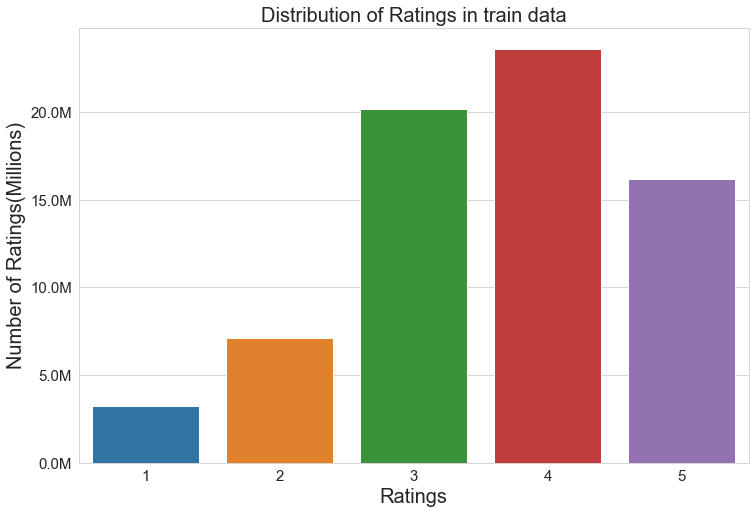

In [8]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=X_train)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [117]:
X_train["DayOfWeek"] = X_train.Date.dt.weekday_name

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# create a new data frame with the death counts grouped by day of the week 
# reindex is used to order the week days in a logical order (learned from https://stackoverflow.com/questions/47741400/pandas-dataframe-group-and-sort-by-weekday)
df_weekday = X_train["Ratings"].copy().groupby(X_train['Date'].dt.weekday_name).count().reindex(days)
df_weekday

Date
Monday       12125092
Tuesday      12448868
Wednesday    11718096
Thursday     10132714
Friday        9383016
Saturday      7019355
Sunday        7509213
Name: Ratings, dtype: int64

In [119]:
df_weekday=pd.DataFrame(df_weekday,index=None,columns=None)

In [125]:
df_weekday

,Date,Ratings
0,Monday,12125092
1,Tuesday,12448868
2,Wednesday,11718096
3,Thursday,10132714
4,Friday,9383016
5,Saturday,7019355
6,Sunday,7509213


In [121]:
df_weekday=df_weekday.reset_index()

### Analysis of Movie Ratings on Day of Week

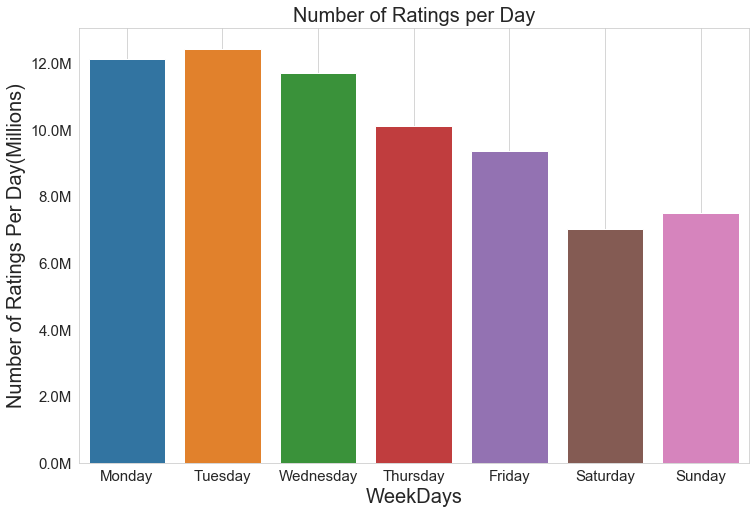

In [126]:
plt.figure(figsize = (12,8))
axy=sns.barplot(x="Date", y="Ratings", data=df_weekday)
axy.set_title("Number of Ratings per Day", fontsize = 20)
axy.set_xlabel("WeekDays", fontsize = 20)
axy.set_ylabel("Number of Ratings Per Day(Millions)", fontsize = 20)
axy.set_yticklabels([changingLabels(num) for num in axy.get_yticks()])
axy.tick_params(labelsize = 15)
plt.grid()

In [ ]:
X_train.head()

# Number of Ratings per month

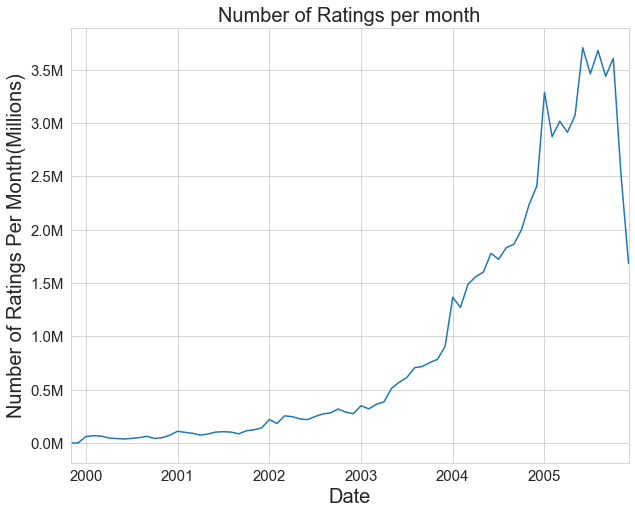

In [35]:
plt.figure(figsize = (10,8))
ax = X_train.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.show()

# Analysis of Ratings given by user

In [10]:
no_of_rated_movies_per_user = X_train.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [11]:
no_of_rated_movies_per_user.shape

(479526,)

In [23]:
no_of_rated_movies_per_user.head()

CustID
305344     12406
387418     12165
2439493    11563
1664010    11058
2118461    10347
Name: Ratings, dtype: int64

# Analysis of Ratings Per Movie

In [24]:
no_of_ratings_per_movie = X_train.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

In [25]:
no_of_ratings_per_movie.head()

MovieID
5317     162947
15124    151731
14313    140448
15205    137534
1905     135950
Name: Ratings, dtype: int64

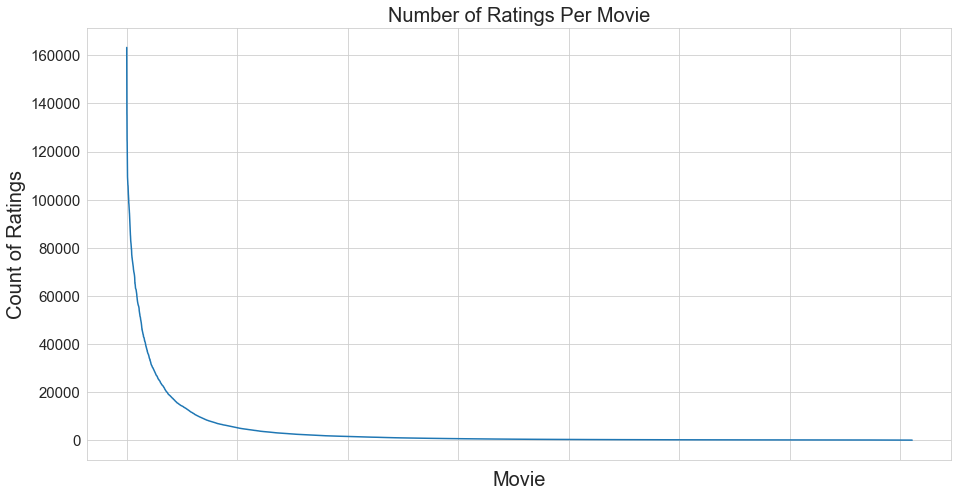

In [28]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

### Analysis of Movie Ratings on Day of Week

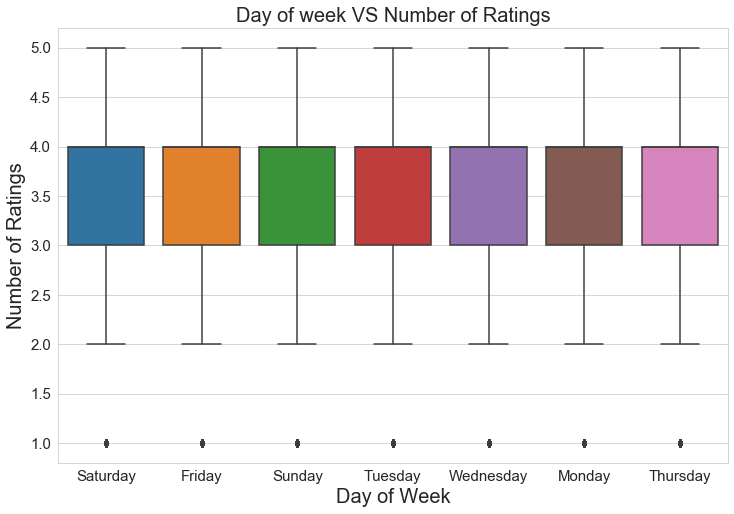

In [30]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayOfWeek", y = "Ratings", data = X_train)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [45]:
average_ratings_dayofweek = X_train.groupby(by = "DayOfWeek")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.605913
Monday       3.597540
Saturday     3.614853
Sunday       3.616528
Thursday     3.604287
Tuesday      3.595831
Wednesday    3.604946
Name: Ratings, dtype: float64


# Creating USER-ITEM sparse matrix from data frame

In [11]:
%%time
print("Creating USER_ITEM sparse matrix for train Data")
TrainUISparseData = sparse.csr_matrix((X_train.Ratings, (X_train.CustID, X_train.MovieID)))
print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))

Creating USER_ITEM sparse matrix for train Data
Creation done. Shape of sparse matrix = (2649297, 17766)
Wall time: 272 ms


In [12]:
%%time
print("Creating USER_ITEM sparse matrix for test Data")
TestUISparseData = sparse.csr_matrix((X_test.Ratings, (X_test.CustID, X_test.MovieID)))
print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))

Creating USER_ITEM sparse matrix for test Data
Creation done. Shape of sparse matrix = (2649297, 17766)
Wall time: 53.4 ms


In [92]:
TrainUISparseData

<2648798x17765 sparse matrix of type '<class 'numpy.int64'>'
	with 70000 stored elements in Compressed Sparse Row format>

In [36]:
%%time
#creating cosine similarity matirx of train Data
print("Creating Cosine Similarity Matrix...")
print("Creation Done..")
m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)

Creating Cosine Similarity Matrix...
Creation Done..
Wall time: 818 ms


In [14]:
print("Dimension of Matrix = {}".format(m_m_similarity.shape))

Dimension of Matrix = (17766, 17766)


In [15]:
m_m_similarity

<17766x17766 sparse matrix of type '<class 'numpy.float64'>'
	with 7909315 stored elements in Compressed Sparse Row format>

In [18]:
print('pairwise sparse output:\n {}\n'.format(m_m_similarity))

pairwise sparse output:
   (7, 17560)	0.013441012737817013
  (7, 17063)	0.2866297455600074
  (7, 17004)	0.016095222024355493
  (7, 16997)	0.012954703541703815
  (7, 16793)	0.01626058058301215
  (7, 16788)	0.016180620184224056
  (7, 16721)	0.013683766411279628
  (7, 16668)	0.009282011165189431
  (7, 16532)	0.03131481251055252
  (7, 16128)	0.014934186663951634
  (7, 15894)	0.015554850375648722
  (7, 15755)	0.008273615413522915
  (7, 15525)	0.21629522817435004
  (7, 15440)	0.02542966504301125
  (7, 15422)	0.012569283824653376
  (7, 15154)	0.022660071028103954
  (7, 15057)	0.011233788526998634
  (7, 14889)	0.017271408326331786
  (7, 14869)	0.012181217343619382
  (7, 14670)	0.013647400217437183
  (7, 14667)	0.006743330180665651
  (7, 14584)	0.006236259132031637
  (7, 14507)	0.00959392628093864
  (7, 14482)	0.008936203182521633
  (7, 14480)	0.028034131306548943
  :	:
  (17765, 2252)	0.056112877973557296
  (17765, 2209)	0.01592344987286945
  (17765, 2178)	0.014889477998144562
  (17765, 2163)	

In [16]:
%%time
movie_ids = np.unique(m_m_similarity.nonzero())

Wall time: 618 ms


In [17]:
%%time
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

Wall time: 1.81 s


### Let's pick random movie and check it's top 10 most similar movies.

In [39]:
movie_titles = pd.read_csv("movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'],
                           index_col = "MovieID", encoding = "iso8859_2")

### Merge movie Titles with MovieID

In [40]:
movie_data=pd.merge(movie_titles,Final_Data,on='MovieID')

In [28]:
movie_data.head()

,MovieID,Year_of_Release,Movie_Title,CustID,Ratings,Date
0,12,1947.0,My Favorite Brunette,529889,3,2000-01-14
1,12,1947.0,My Favorite Brunette,2594013,3,2000-01-16
2,15,1988.0,Neil Diamond: Greatest Hits Live,107840,3,2000-01-13
3,16,1996.0,Screamers,1066384,2,2000-01-07
4,16,1996.0,Screamers,1356928,3,2000-01-07


In [21]:
movie_titles.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


#### Similar Movies to: Godzilla's Revenge

In [21]:
movieID_GR = 17765

print("Name of the movie -------> "+str(movie_titles.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Godzilla's Revenge


IndexError: index out of bounds: 0 <= 17765 <= 17765, 0 <= 17766 <= 17765, 17765 <= 17766

In [16]:
movie_titles.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
12252,1975.0,Terror of Mechagodzilla
15810,1964.0,Godzilla vs. Mothra
5907,1956.0,Godzilla: King of the Monsters
2459,1967.0,Son of Godzilla
409,1966.0,Godzilla vs. The Sea Monster
8656,1993.0,Godzilla vs. Mechagodzilla II
10064,2004.0,Godzilla: The Series: Monster Wars Trilogy
15123,1995.0,Godzilla vs. Destroyah / Godzilla vs. Space Go...
10181,1999.0,Godzilla And Other Movie Monsters


In [17]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

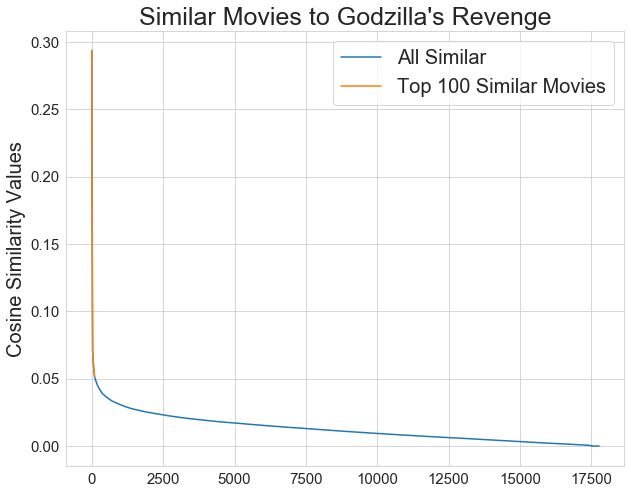

In [25]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Godzilla's Revenge", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

#### Similar Movies to: Aap mujhe aache lagne lage

In [39]:
movieID_GR = 948

print("Name of the movie -------> "+str(movie_titles.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Aap Mujhe Achche Lagne Lage
Number of ratings by users for movie Aap Mujhe Achche Lagne Lage is 97
Number of similar movies to Aap Mujhe Achche Lagne Lage is 17539


In [27]:
movie_titles.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
2364,2002.0,Na Tum Jaano Na Hum
8234,2003.0,Main Prem Ki Diwani Hoon
13011,2000.0,Kaho Naa Pyaar Hai
5098,2001.0,Pyaar Ishq aur Mohabbat
16692,2001.0,Chori Chori Chupke Chupke
4967,1999.0,Jaanam Samjha Karo
13733,2000.0,Fiza
17651,2001.0,Tum Bin
13700,2002.0,Hum Tumhare Hain Sanam


#### Similar Movies to: Dil hai tmhara

In [35]:
movieID_GR = 16893

print("Name of the movie -------> "+str(movie_titles.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

movie_titles.loc[similar_movies_dict[movieID_GR][:10]]

Name of the movie -------> Dil Hai Tumhaara
Number of ratings by users for movie Dil Hai Tumhaara is 125
Number of similar movies to Dil Hai Tumhaara is 17626


,Year_of_Release,Movie_Title
MovieID,,
2364,2002.0,Na Tum Jaano Na Hum
5484,2000.0,Har dil jo Pyar karega...
5439,2001.0,Yaadein
5719,2000.0,Dhadkan
14676,2003.0,Tere Naam: The Movie
16692,2001.0,Chori Chori Chupke Chupke
12410,2000.0,Kya Kehna
17651,2001.0,Tum Bin
16132,1995.0,Karan Arjun


## Define a function for recommendation System

In [43]:
k=3
def Movie_recommendation():
    for Movie_recommendation in range(k):
        movieID_GR=0
        try:
            movieID_GR= int(input("Enter the Movie ID :"))
            if(movieID_GR<17770):                
                break
            else:
                print("Invalid entry")
        except ValueError:
            print("Invalid Input")
    if(movieID_GR==0):
        return
    cprint ("\nName of the movie -------> "+str(movie_titles.loc[movieID_GR][1]),'blue',attrs=['underline','dark','bold'])
    cprint("\nNumber of ratings by users for movie {} is {}".format(movie_titles.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()),'red', attrs=['underline','bold'])
    cprint("\nNumber of similar movies to {} is {}".format(movie_titles.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()),'grey',attrs=['underline','bold'])
    cprint("\nTop 10 Similar Movies \n\n"+str(pd.DataFrame(movie_titles.loc[similar_movies_dict[movieID_GR][:10]])),attrs=['bold'])

In [45]:
Movie_recommendation()

Enter the Movie ID :324

Name of the movie -------> Mother's Boys

Number of ratings by users for movie Mother's Boys is 5

Number of similar movies to Mother's Boys is 955

Top 10 Similar Movies 

         Year_of_Release                            Movie_Title
MovieID                                                        
2708              1999.0            Candyman 3: Day of the Dead
3931              1990.0                      A Cry in the Wild
3164              1937.0                          Stella Dallas
16456             1998.0                                Kolobos
3976              2000.0  The Miracle Maker: The Story of Jesus
13625             1975.0                            Cooley High
15146             1963.0             Beach Party / Bikini Beach
5106              1994.0                          House Party 3
15286             1996.0                             Diabolique
751               1998.0                         Halloween: H2O


In [46]:
movie_new = pd.read_csv("movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'],
                         encoding = "iso8859_2")

In [47]:
movie_new.tail()

,MovieID,Year_of_Release,Movie_Title
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company
17769,17770,2003.0,Alien Hunter


In [48]:
movie_new=movie_new.drop(columns=['Year_of_Release'])

In [49]:
int(movie_new[movie_new['Movie_Title'].str.match("Godzilla's Revenge")]["MovieID"].values)

17765

In [51]:
k=3
def get_similar_movies():
    for VMRS in range(k):
        movieID_GR=0
        try:
            name=input("Enter Movie Name:")
            movieID_GR=int(movie_new[movie_new['Movie_Title'].str.match(name)]["MovieID"].values)
            print("\nMovie ID :",movieID_GR)
            #movieID_GR= int(input("Enter the Movie ID :"))
            if(movieID_GR<17770):                
                break
            else:
                print("Invalid entry")
        except ValueError:
            print("Invalid Input")
    if(movieID_GR==0):
        return
    
    cprint ("\nName of the movie -------> "+str(movie_titles.loc[movieID_GR][1]),'blue',attrs=['underline','dark','bold'])
    cprint("\nNumber of ratings by users for movie {} is {}".format(movie_titles.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()),'red', attrs=['underline','bold'])
    cprint("\nNumber of similar movies to {} is {}".format(movie_titles.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()),'grey',attrs=['underline','bold'])
    cprint("\nTop 10 Similar Movies \n\n"+str(pd.DataFrame(movie_titles.loc[similar_movies_dict[movieID_GR][:10]])),attrs=['bold'])

In [53]:
#function use for finding the similar movies
get_similar_movies()

Enter Movie Name:Godzilla's Revenge

Movie ID : 17765

Name of the movie -------> Godzilla's Revenge

Number of ratings by users for movie Godzilla's Revenge is 4

Number of similar movies to Godzilla's Revenge is 1703

Top 10 Similar Movies 

         Year_of_Release                                        Movie_Title
MovieID                                                                    
6293              1998.0                                         The Colony
3761              1999.0  Salsa & Merengue: Cal Pozo's Learn to Dance in...
14846             1922.0                                 Cyrano de Bergerac
1635              1997.0                               Striking Resemblance
10181             1999.0                  Godzilla And Other Movie Monsters
13221             1999.0                                        Rowdy Girls
9318              1979.0                                 The Real Bruce Lee
12048             1999.0               Timegate: Tales of the Saddle Tra

# Train KNN model for item-based collaborative filtering

In [31]:
# pivot and create movie-user matrix
movie_user_mat = Final_Data.pivot(index='MovieID', columns='CustID', values='Ratings').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movie_new.set_index('MovieID').loc[movie_user_mat.index].Movie_Title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [32]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(TrainUISparseData)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

 ## Use this trained model to make movie recommendations to myself


In [33]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [36]:
my_favorite = "Stand by Me"
make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Stand by Me
Found possible matches in our database: ['Stand by Me', 'Pat and Mike']

Recommendation system start to make inference
......

Recommendations for Stand by Me:
1: Lethal Weapon, with distance of 0.4263755481655076
2: Ferris Bueller's Day Off, with distance of 0.42565386718607534
3: The Terminator, with distance of 0.42281827929838756
4: A Few Good Men, with distance of 0.42169156484558834
5: Ghostbusters, with distance of 0.42065292633016227
6: Good Morning, with distance of 0.41930667995010373
7: The Silence of the Lambs, with distance of 0.4192929214088327
8: Die Hard, with distance of 0.41566023265570684
9: Big, with distance of 0.411291169899234
10: The Fugitive, with distance of 0.4078886605064338
